<a href="https://colab.research.google.com/github/isaroyston/DSA4213_Project/blob/model3/BERTopic%20(prompting).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Modelling Notebook

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from bertopic import BERTopic
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import torch
from sklearn.metrics import davies_bouldin_score


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [115]:
import numpy as np
import pandas as pd

# Load the file
path_train = r"/content/general_train_broad_embeddings.npz" # path to npz file
data_train = np.load(path_train, allow_pickle=True)
path_test = r"/content/general_test_broad_embeddings.npz" # path to npz file
data_test = np.load(path_test, allow_pickle=True)

print({k: data_train[k].shape for k in data_train.files})

embeddings_train = pd.DataFrame(data_train["embeddings"])
embeddings_train.columns = [f"emb_{i}" for i in range(embeddings_train.shape[1])]  # rename nicely
embeddings_train["text"] = data_train["texts"]
embeddings_train["label"] = data_train["labels"]

embeddings_test = pd.DataFrame(data_test["embeddings"])
embeddings_test.columns = [f"emb_{i}" for i in range(embeddings_test.shape[1])]  # rename nicely
embeddings_test["text"] = data_test["texts"]
embeddings_test["label"] = data_test["labels"]

print(embeddings_train.shape)
print(embeddings_train.head())

print(embeddings_test.shape)
print(embeddings_test.head())


{'embeddings': (11200, 384), 'texts': (11200,), 'labels': (11200,)}
(11200, 386)
      emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0 -0.065954  0.129986 -0.027290  0.022978 -0.060881  0.020859 -0.097683   
1 -0.002380  0.061337  0.029013  0.004403 -0.013388 -0.011926 -0.017382   
2 -0.020936  0.029716  0.003486  0.019713 -0.003231  0.021080 -0.052675   
3 -0.100052  0.001816 -0.010476 -0.046205  0.034331 -0.054387  0.107253   
4 -0.011559 -0.028765  0.057984  0.075947  0.047227 -0.019874  0.011059   

      emb_7     emb_8     emb_9  ...   emb_376   emb_377   emb_378   emb_379  \
0  0.023718 -0.103246 -0.029989  ... -0.049650 -0.002975  0.014075 -0.105049   
1  0.044410 -0.059244 -0.088396  ... -0.055617  0.069392  0.007593  0.106782   
2  0.079947 -0.039729  0.032833  ... -0.047487  0.079180 -0.075348  0.085130   
3  0.026428  0.038723 -0.113006  ... -0.057479  0.006368 -0.001778  0.022304   
4  0.044840 -0.066399 -0.011631  ... -0.051420 -0.055166  0.038959  

In [116]:
texts = data_train["texts"]
labels = data_train["labels"]
emb_matrix = data_train["embeddings"]  # shape: (11200, 384)

train_df = pd.DataFrame({
    "text": texts,
    "label": labels,
    "embeddings": [vec.tolist() for vec in emb_matrix]
})

texts = data_test["texts"]
labels = data_test["labels"]
emb_matrix = data_test["embeddings"]  # shape: (11200, 384)

test_df = pd.DataFrame({
    "text": texts,
    "label": labels,
    "embeddings": [vec.tolist() for vec in emb_matrix]
})
print(train_df.shape, test_df.shape)

(11200, 3) (7430, 3)


In [117]:
train_df

,text,label,embeddings
0,i was wondering if anyone out there could enli...,3,"[-0.06595448404550552, 0.1299862116575241, -0...."
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795582819730043, 0.06133740022778511, ..."
2,well folks my mac plus finally gave up the gho...,1,"[-0.020935580134391785, 0.029716163873672485, ..."
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005172342061996, 0.001815522089600563, -..."
4,from article by tom a baker my understanding i...,2,"[-0.011558877304196358, -0.028764871880412102,..."
...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230957388877869, -0.0048754564486444, 0...."
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424371778964996, -0.012400449253618717, 0..."
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.0244490597397089, -0.014120903797447681, 0..."
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212789237499237, -0.06897043436765671, -0..."


# Topic Modeling

## Init topic model

In [118]:
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
SEED = 42
from bertopic import BERTopic

# custom words to ignore
CUSTOM_STOPWORDS = []

# Pass your own preprocessor to remove them
def custom_preprocessor(text):
    text = text.lower()
    for w in CUSTOM_STOPWORDS:
        text = text.replace(w, " ")  # simple remove
    return text

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)


vectorizer_model = CountVectorizer(
    stop_words="english",     # remove stopwords for topic representation
    preprocessor=custom_preprocessor,
    ngram_range=(1, 1),       # unigrams + bigrams (tweak if needed)
    min_df=1,                 # drop very rare terms
    max_df=1.0
)

topic_model = BERTopic(
    embedding_model=None,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    low_memory=True,
    calculate_probabilities=True,
    verbose=True,
    nr_topics= 20,                   # keep all topics (no reduction)
)

print("BERTopic initialized with fixed random seed:", SEED)

BERTopic initialized with fixed random seed: 42


In [119]:
docs = embeddings_train["text"].tolist()
embeddings_train = embeddings_train[[f"emb_{i}" for i in range(embeddings_train.shape[1]-2)]].to_numpy()

topics, probs = topic_model.fit_transform(docs, embeddings_train)
print("Unique topics (excl. -1 outliers):", sorted(t for t in set(topics) if t != -1))

2025-10-26 11:47:16,183 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-10-26 11:47:26,303 - BERTopic - Dimensionality - Completed ✓
2025-10-26 11:47:26,304 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-10-26 11:47:34,634 - BERTopic - Cluster - Completed ✓
2025-10-26 11:47:34,635 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-10-26 11:47:36,359 - BERTopic - Representation - Completed ✓
2025-10-26 11:47:36,363 - BERTopic - Topic reduction - Reducing number of topics
2025-10-26 11:47:36,406 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-10-26 11:47:38,075 - BERTopic - Representation - Completed ✓
2025-10-26 11:47:38,081 - BERTopic - Topic reduction - Reduced number of topics from 142 to 20


Unique topics (excl. -1 outliers): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [120]:
train_df["Topic"] = topics
train_df["Topic_Probability"] = [max(p) if p is not None else None for p in probs]
train_df

,text,label,embeddings,Topic,Topic_Probability
0,i was wondering if anyone out there could enli...,3,"[-0.06595448404550552, 0.1299862116575241, -0....",10,0.479913
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795582819730043, 0.06133740022778511, ...",-1,0.239952
2,well folks my mac plus finally gave up the gho...,1,"[-0.020935580134391785, 0.029716163873672485, ...",3,1.000000
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005172342061996, 0.001815522089600563, -...",4,0.014388
4,from article by tom a baker my understanding i...,2,"[-0.011558877304196358, -0.028764871880412102,...",7,0.130016
...,...,...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230957388877869, -0.0048754564486444, 0....",-1,0.276641
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424371778964996, -0.012400449253618717, 0...",-1,0.048379
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.0244490597397089, -0.014120903797447681, 0...",-1,0.125220
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212789237499237, -0.06897043436765671, -0...",5,1.000000


In [121]:
topic_info = topic_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,3956,-1_writes_article_like_dont,"[writes, article, like, dont, just, use, know,...",[archivename graphicsresourceslistpart1 lastmo...
1,0,1122,0_team_game_games_season,"[team, game, games, season, hockey, play, year...",[i finally got it back with great thanks to ma...
2,1,936,1_god_jesus_writes_people,"[god, jesus, writes, people, believe, article,...",[robert weiss writes rick anderson replied to ...
3,2,684,2_gun_people_dont_mr,"[gun, people, dont, mr, guns, think, president...",[in article thomas parsli writes so like what ...
4,3,671,3_drive_card_disk_drives,"[drive, card, disk, drives, scsi, controller, ...",[from article by grubb tons of stuff deleted o...


In [122]:
topic_model.visualize_barchart()

In [123]:
topic_model.visualize_topics()

## Use Gemini to label topics

In [175]:
import os
from dotenv import load_dotenv

# Force-load the uploaded .env file (replace filename if needed)
env_path = "/content/.env"

load_dotenv(dotenv_path=env_path, override=True)  # override old values if already set

# Check if key is visible
api_key = os.getenv("GEMINI_API_KEY")
print("GEMINI_API_KEY:", api_key[:6], "..." if api_key else "MISSING")


GEMINI_API_KEY: AIzaSy ...


In [125]:
import sys
sys.path.append("/content") # path to destination that contains gemini_utils
from gemini_utils import label_topics_from_df
import time

In [126]:

# --- CONFIG ---
NUM_BATCHES = 2
WAIT_TIME_SEC = 60  # 1 minute between batches

# Split into ~10 equal chunks
batches = np.array_split(topic_info, NUM_BATCHES)

labels_list = []

for i, batch in enumerate(batches, start=1):
    print(f"Processing batch {i}/{NUM_BATCHES} with {len(batch)} topics...")

    try:
        # Call your API function
        labels_chunk = label_topics_from_df(batch, api_key=api_key)
        labels_list.append(labels_chunk)
        print(f"Batch {i} done. Waiting {WAIT_TIME_SEC}s before next batch...")

    except Exception as e:
        print(f"Error in batch {i}: {e}")
        continue

    # Wait before next API call, unless this was the last batch
    if i < NUM_BATCHES:
        time.sleep(WAIT_TIME_SEC)

# Merge all labeled results
labels_df = pd.concat(labels_list, ignore_index=True)

# Merge back with original topic_info
final_df = topic_info.merge(labels_df, on="Topic", how="left")

display(final_df.head())
print("All batches completed.")

Processing batch 1/2 with 10 topics...
tuned_topic_name='Sports' short_explanation='This cluster is about sports, focusing on games, teams, and seasons, with specific mentions of hockey and tabletop baseball.'
tuned_topic_name='Religion' short_explanation='This cluster focuses on discussions related to religious figures like God and Jesus, beliefs, and atheism, often within forum or group contexts.'
tuned_topic_name='Politics & Society' short_explanation='This cluster is centered on discussions about gun control and related societal and political issues, often referencing official government communications.'
tuned_topic_name='Computers & Technology' short_explanation='This cluster is focused on computer hardware, specifically storage devices like hard drives, disks, and SCSI interfaces, along with associated components such as cards.'
tuned_topic_name='Computers & Technology' short_explanation='This cluster focuses on discussions around digital security, encryption technologies, and sp

,Topic,Count,Name,Representation,Representative_Docs,tuned_topic_name,short_explanation
0,-1,3956,-1_writes_article_like_dont,"[writes, article, like, dont, just, use, know,...",[archivename graphicsresourceslistpart1 lastmo...,NaN,NaN
1,0,1122,0_team_game_games_season,"[team, game, games, season, hockey, play, year...",[i finally got it back with great thanks to ma...,Sports,"This cluster is about sports, focusing on game..."
2,1,936,1_god_jesus_writes_people,"[god, jesus, writes, people, believe, article,...",[robert weiss writes rick anderson replied to ...,Religion,This cluster focuses on discussions related to...
3,2,684,2_gun_people_dont_mr,"[gun, people, dont, mr, guns, think, president...",[in article thomas parsli writes so like what ...,Politics & Society,This cluster is centered on discussions about ...
4,3,671,3_drive_card_disk_drives,"[drive, card, disk, drives, scsi, controller, ...",[from article by grubb tons of stuff deleted o...,Computers & Technology,"This cluster is focused on computer hardware, ..."


All batches completed.


In [127]:
# join finetuned back to main dataframe
# plot number of each topic in each department
train_df = train_df.merge(labels_df[["Topic", "tuned_topic_name", "short_explanation"]], on="Topic", how="left")
train_df

,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation
0,i was wondering if anyone out there could enli...,3,"[-0.06595448404550552, 0.1299862116575241, -0....",10,0.479913,Marketplace / Miscellaneous,This cluster discusses the auction and sale of...
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795582819730043, 0.06133740022778511, ...",-1,0.239952,NaN,NaN
2,well folks my mac plus finally gave up the gho...,1,"[-0.020935580134391785, 0.029716163873672485, ...",3,1.000000,Computers & Technology,"This cluster is focused on computer hardware, ..."
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005172342061996, 0.001815522089600563, -...",4,0.014388,Computers & Technology,This cluster focuses on discussions around dig...
4,from article by tom a baker my understanding i...,2,"[-0.011558877304196358, -0.028764871880412102,...",7,0.130016,Science & Engineering,This cluster focuses on advancements and news ...
...,...,...,...,...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230957388877869, -0.0048754564486444, 0....",-1,0.276641,NaN,NaN
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424371778964996, -0.012400449253618717, 0...",-1,0.048379,NaN,NaN
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.0244490597397089, -0.014120903797447681, 0...",-1,0.125220,NaN,NaN
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212789237499237, -0.06897043436765671, -0...",5,1.000000,Computers & Technology,This cluster covers topics related to computer...


In [128]:
CATEGORY_NAME_MAP = {
    1: "Computers & Technology",
    2: "Science & Engineering",
    3: "Recreation (Vehicles & Hobbies)",
    4: "Sports",
    5: "Religion",
    6: "Politics & Society",
    7: "Marketplace / Miscellaneous"
}
CATEGORY_NAME_TO_INT = {v: k for k, v in CATEGORY_NAME_MAP.items()}
train_df["predicted_topic_id"] = train_df["tuned_topic_name"].map(CATEGORY_NAME_TO_INT)
train_df["predicted_topic_id"] = train_df["predicted_topic_id"].fillna(-1).astype(int)
train_df


,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation,predicted_topic_id
0,i was wondering if anyone out there could enli...,3,"[-0.06595448404550552, 0.1299862116575241, -0....",10,0.479913,Marketplace / Miscellaneous,This cluster discusses the auction and sale of...,7
1,a fair number of brave souls who upgraded thei...,1,"[-0.0023795582819730043, 0.06133740022778511, ...",-1,0.239952,NaN,NaN,-1
2,well folks my mac plus finally gave up the gho...,1,"[-0.020935580134391785, 0.029716163873672485, ...",3,1.000000,Computers & Technology,"This cluster is focused on computer hardware, ...",1
3,robert jc kyanko wrote do you have weiteks add...,1,"[-0.10005172342061996, 0.001815522089600563, -...",4,0.014388,Computers & Technology,This cluster focuses on discussions around dig...,1
4,from article by tom a baker my understanding i...,2,"[-0.011558877304196358, -0.028764871880412102,...",7,0.130016,Science & Engineering,This cluster focuses on advancements and news ...,2
...,...,...,...,...,...,...,...,...
11195,dn from david nye dn a neurology dn consultati...,2,"[-0.08230957388877869, -0.0048754564486444, 0....",-1,0.276641,NaN,NaN,-1
11196,i have a very old mac 512k and a mac plus both...,1,"[0.03424371778964996, -0.012400449253618717, 0...",-1,0.048379,NaN,NaN,-1
11197,i just installed a dx266 cpu in a clone mother...,1,"[-0.0244490597397089, -0.014120903797447681, 0...",-1,0.125220,NaN,NaN,-1
11198,in article edward bolson writes wouldnt this r...,1,"[0.04212789237499237, -0.06897043436765671, -0...",5,1.000000,Computers & Technology,This cluster covers topics related to computer...,1


<Axes: title={'center': 'Predicted Topic ID Distribution in Training Set'}, xlabel='Predicted Topic ID', ylabel='Count'>

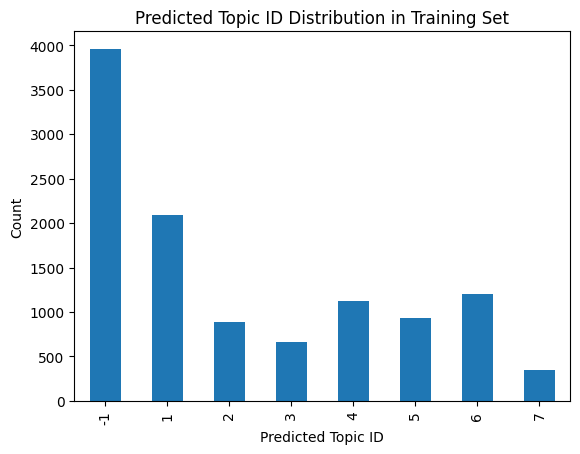

In [129]:
train_df.predicted_topic_id.value_counts().sort_index().plot(kind='bar', title='Predicted Topic ID Distribution in Training Set', xlabel='Predicted Topic ID', ylabel='Count')

Original samples: 11200
After removing outliers (Topic=-1): 7244
Outliers removed: 3956 (35.32%)

After removing unmapped predictions: 7244

[Saved] results/category_alignment/default_metrics.json


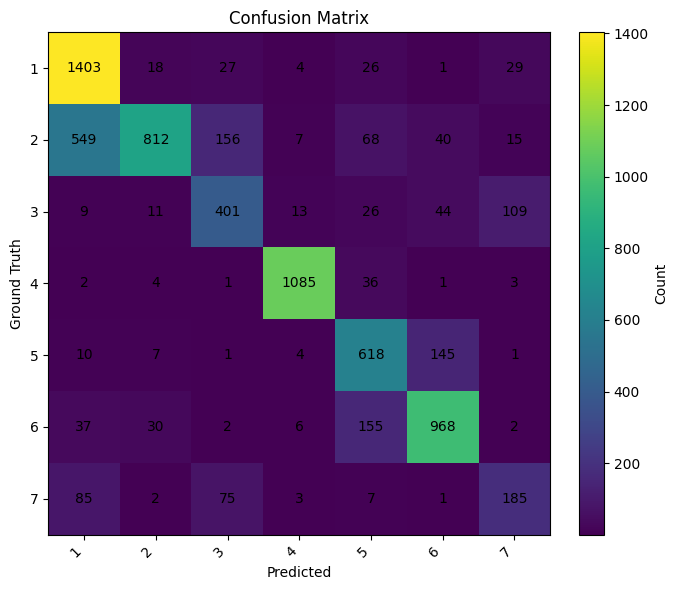

{'macro_f1': 0.7233144087083628,
 'weighted_f1': 0.7491948897247293,
 'per_class_f1': [0.7787954482375798,
  0.6416436191228764,
  0.6285266457680251,
  0.9627329192546584,
  0.7177700348432056,
  0.8066666666666666,
  0.5270655270655271],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'confusion_matrix': [[1403, 18, 27, 4, 26, 1, 29],
  [549, 812, 156, 7, 68, 40, 15],
  [9, 11, 401, 13, 26, 44, 109],
  [2, 4, 1, 1085, 36, 1, 3],
  [10, 7, 1, 4, 618, 145, 1],
  [37, 30, 2, 6, 155, 968, 2],
  [85, 2, 75, 3, 7, 1, 185]]}

In [130]:
import sys
sys.path.append("/content") # path to destination that contains category_alignment.py inside
from category_alignment import compute_category_alignment

# Filter out outliers (Topic = -1) before evaluation
train_df_filtered = train_df[train_df["Topic"] != -1].copy()

print(f"Original samples: {len(train_df)}")
print(f"After removing outliers (Topic=-1): {len(train_df_filtered)}")
print(f"Outliers removed: {len(train_df) - len(train_df_filtered)} ({100*(len(train_df) - len(train_df_filtered))/len(train_df):.2f}%)")
print()

# Also filter out any predictions that are -1 (unmapped categories)
train_df_filtered = train_df_filtered[train_df_filtered["predicted_topic_id"] != -1].copy()
print(f"After removing unmapped predictions: {len(train_df_filtered)}")
print()

# Compute metrics on filtered data
compute_category_alignment(
    train_df_filtered["predicted_topic_id"].astype('int64'),
    train_df_filtered["label"].astype('int64'),
    plot_confusion=True
)

# Testing on test set

In [131]:
# load topic model and test embeddings
docs = embeddings_test["text"].tolist()
embeddings_test = embeddings_test[[f"emb_{i}" for i in range(embeddings_test.shape[1]-2)]].to_numpy()

topics_test, probs_test = topic_model.transform(docs, embeddings_test)

2025-10-26 11:50:00,099 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-10-26 11:50:05,856 - BERTopic - Dimensionality - Completed ✓
2025-10-26 11:50:05,857 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-10-26 11:50:06,241 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-10-26 11:50:11,497 - BERTopic - Probabilities - Completed ✓
2025-10-26 11:50:11,498 - BERTopic - Cluster - Completed ✓


In [132]:
test_df["Topic"] = topics_test
test_df["Topic_Probability"] = [max(p) if p is not None else None for p in probs_test]
test_df

,text,label,embeddings,Topic,Topic_Probability
0,i am a little confused on all of the models of...,3,"[-0.09357891976833344, -0.00967082753777504, 0...",-1,0.196028
1,im not familiar at all with the format of thes...,1,"[-0.07837390154600143, 0.008786031045019627, -...",-1,0.119534
2,turin turambar me department of utter misery w...,5,"[-0.019032953307032585, 0.06360289454460144, 0...",-1,0.437702
3,in article ilyess b bdira writes they were att...,6,"[0.023197060450911522, -0.01774839125573635, 0...",-1,0.320606
4,in article norman r paterson writes in article...,5,"[-0.030304575338959694, -0.03915150836110115, ...",1,0.303484
...,...,...,...,...,...
7425,henry spencer writes henry if i read you corre...,2,"[-0.03778068348765373, 0.005880643613636494, 0...",7,0.932817
7426,in article paul nevai writes about them on act...,1,"[-0.026070475578308105, -0.08614318817853928, ...",-1,0.881031
7427,i sent a version of this post out a while ago ...,4,"[0.09013152867555618, 0.06133655458688736, 0.0...",0,0.351545
7428,i have this kit which includes the following 1...,7,"[-0.09830979257822037, 0.09242036938667297, -0...",-1,0.377115


In [133]:
test_df = test_df.merge(labels_df[["Topic", "tuned_topic_name", "short_explanation"]], on="Topic", how="left")
test_df


,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation
0,i am a little confused on all of the models of...,3,"[-0.09357891976833344, -0.00967082753777504, 0...",-1,0.196028,NaN,NaN
1,im not familiar at all with the format of thes...,1,"[-0.07837390154600143, 0.008786031045019627, -...",-1,0.119534,NaN,NaN
2,turin turambar me department of utter misery w...,5,"[-0.019032953307032585, 0.06360289454460144, 0...",-1,0.437702,NaN,NaN
3,in article ilyess b bdira writes they were att...,6,"[0.023197060450911522, -0.01774839125573635, 0...",-1,0.320606,NaN,NaN
4,in article norman r paterson writes in article...,5,"[-0.030304575338959694, -0.03915150836110115, ...",1,0.303484,Religion,This cluster focuses on discussions related to...
...,...,...,...,...,...,...,...
7425,henry spencer writes henry if i read you corre...,2,"[-0.03778068348765373, 0.005880643613636494, 0...",7,0.932817,Science & Engineering,This cluster focuses on advancements and news ...
7426,in article paul nevai writes about them on act...,1,"[-0.026070475578308105, -0.08614318817853928, ...",-1,0.881031,NaN,NaN
7427,i sent a version of this post out a while ago ...,4,"[0.09013152867555618, 0.06133655458688736, 0.0...",0,0.351545,Sports,"This cluster is about sports, focusing on game..."
7428,i have this kit which includes the following 1...,7,"[-0.09830979257822037, 0.09242036938667297, -0...",-1,0.377115,NaN,NaN


In [134]:
CATEGORY_NAME_TO_INT = {v: k for k, v in CATEGORY_NAME_MAP.items()}
test_df["predicted_topic_id"] = test_df["tuned_topic_name"].map(CATEGORY_NAME_TO_INT)
test_df["predicted_topic_id"] = test_df["predicted_topic_id"].fillna(-1).astype(int)
test_df

,text,label,embeddings,Topic,Topic_Probability,tuned_topic_name,short_explanation,predicted_topic_id
0,i am a little confused on all of the models of...,3,"[-0.09357891976833344, -0.00967082753777504, 0...",-1,0.196028,NaN,NaN,-1
1,im not familiar at all with the format of thes...,1,"[-0.07837390154600143, 0.008786031045019627, -...",-1,0.119534,NaN,NaN,-1
2,turin turambar me department of utter misery w...,5,"[-0.019032953307032585, 0.06360289454460144, 0...",-1,0.437702,NaN,NaN,-1
3,in article ilyess b bdira writes they were att...,6,"[0.023197060450911522, -0.01774839125573635, 0...",-1,0.320606,NaN,NaN,-1
4,in article norman r paterson writes in article...,5,"[-0.030304575338959694, -0.03915150836110115, ...",1,0.303484,Religion,This cluster focuses on discussions related to...,5
...,...,...,...,...,...,...,...,...
7425,henry spencer writes henry if i read you corre...,2,"[-0.03778068348765373, 0.005880643613636494, 0...",7,0.932817,Science & Engineering,This cluster focuses on advancements and news ...,2
7426,in article paul nevai writes about them on act...,1,"[-0.026070475578308105, -0.08614318817853928, ...",-1,0.881031,NaN,NaN,-1
7427,i sent a version of this post out a while ago ...,4,"[0.09013152867555618, 0.06133655458688736, 0.0...",0,0.351545,Sports,"This cluster is about sports, focusing on game...",4
7428,i have this kit which includes the following 1...,7,"[-0.09830979257822037, 0.09242036938667297, -0...",-1,0.377115,NaN,NaN,-1


Original samples: 7430
After removing outliers (Topic=-1): 4034
Outliers removed: 3396 (45.71%)

After removing unmapped predictions: 4034

[Saved] results/category_alignment/default_metrics.json


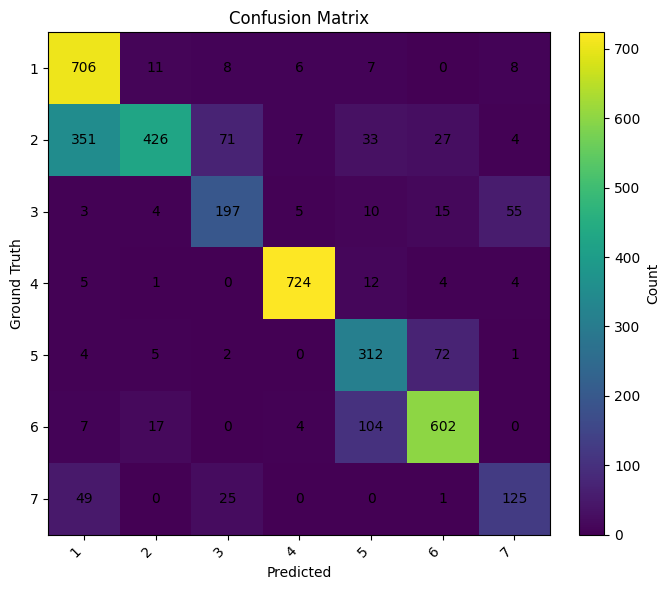

{'macro_f1': 0.7393366891720862,
 'weighted_f1': 0.7594121547582366,
 'per_class_f1': [0.7546766435061465,
  0.6160520607375272,
  0.6655405405405406,
  0.9679144385026738,
  0.7139588100686499,
  0.8274914089347079,
  0.6297229219143576],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'confusion_matrix': [[706, 11, 8, 6, 7, 0, 8],
  [351, 426, 71, 7, 33, 27, 4],
  [3, 4, 197, 5, 10, 15, 55],
  [5, 1, 0, 724, 12, 4, 4],
  [4, 5, 2, 0, 312, 72, 1],
  [7, 17, 0, 4, 104, 602, 0],
  [49, 0, 25, 0, 0, 1, 125]]}

In [135]:


# Filter out outliers (Topic = -1) before evaluation
test_df_filtered = test_df[test_df["Topic"] != -1].copy()

print(f"Original samples: {len(test_df)}")
print(f"After removing outliers (Topic=-1): {len(test_df_filtered)}")
print(f"Outliers removed: {len(test_df) - len(test_df_filtered)} ({100*(len(test_df) - len(test_df_filtered))/len(test_df):.2f}%)")
print()

# Also filter out any predictions that are -1 (unmapped categories)
test_df_filtered = test_df_filtered[test_df_filtered["predicted_topic_id"] != -1].copy()
print(f"After removing unmapped predictions: {len(test_df_filtered)}")
print()

# Compute metrics on filtered data
compute_category_alignment(
    test_df_filtered["predicted_topic_id"].astype('int64'),
    test_df_filtered["label"].astype('int64'),
    plot_confusion=True
)

## Ablation: Changing prompts



The ablaion study below will use different prompting methods such as Chain Of Thought and few-shot prompting.






In [176]:
import sys
sys.path.append("/content") # path to destination that contains ablation_prompt.py
import importlib
import ablation_prompt

importlib.reload(ablation_prompt)
from ablation_prompt import label_topics_from_df, PROMPT_VARIATIONS

GEMINI_API_KEY: AIzaSy ...


In [144]:
# Show available prompts
print("Available prompts:")
for name in PROMPT_VARIATIONS.keys():
    print(f"  - {name}")

Available prompts:
  - baseline
  - no_others
  - cot
  - few_shot


In [145]:
print("train_df columns:", train_df.columns.tolist())
print("test_df columns:", test_df.columns.tolist())
print("topic_info columns:", topic_info.columns.tolist())
print("labels_df columns:", labels_df.columns.tolist())

train_df columns: ['text', 'label', 'embeddings', 'Topic', 'Topic_Probability', 'tuned_topic_name', 'short_explanation', 'predicted_topic_id']
test_df columns: ['text', 'label', 'embeddings', 'Topic', 'Topic_Probability', 'tuned_topic_name', 'short_explanation', 'predicted_topic_id']
topic_info columns: ['Topic', 'Count', 'Name', 'Representation', 'Representative_Docs']
labels_df columns: ['Topic', 'tuned_topic_name', 'short_explanation']


In [139]:
print(topic_info.shape)

(20, 5)



Running prompt: baseline 
Batch 1/2 (10 topics)...
Batch 2/2 (9 topics)...
[Saved] results/category_alignment/baseline_metrics.json


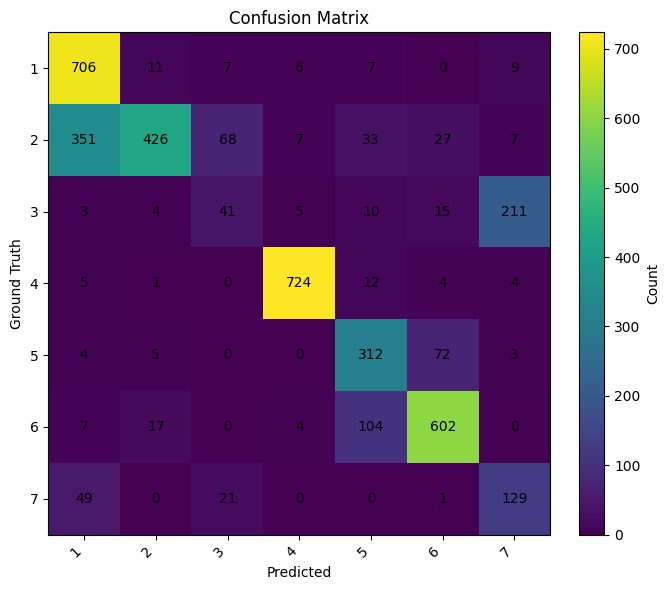


Results for baseline:
{'confusion_matrix': [[706, 11, 7, 6, 7, 0, 9],
                      [351, 426, 68, 7, 33, 27, 7],
                      [3, 4, 41, 5, 10, 15, 211],
                      [5, 1, 0, 724, 12, 4, 4],
                      [4, 5, 0, 0, 312, 72, 3],
                      [7, 17, 0, 4, 104, 602, 0],
                      [49, 0, 21, 0, 0, 1, 129]],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'macro_f1': 0.6472629928149869,
 'per_class_f1': [0.7546766435061465,
                  0.6160520607375272,
                  0.19248826291079812,
                  0.9679144385026738,
                  0.7139588100686499,
                  0.8274914089347079,
                  0.458259325044405],
 'weighted_f1': 0.7170212703732625}

Running prompt: no_others 
Batch 1/2 (10 topics)...
Batch 2/2 (9 topics)...
[Saved] results/category_alignment/no_others_metrics.json


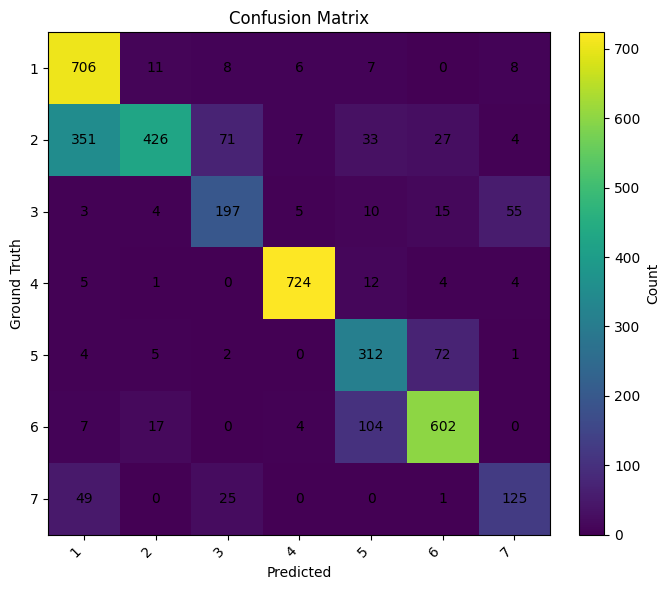


Results for no_others:
{'confusion_matrix': [[706, 11, 8, 6, 7, 0, 8],
                      [351, 426, 71, 7, 33, 27, 4],
                      [3, 4, 197, 5, 10, 15, 55],
                      [5, 1, 0, 724, 12, 4, 4],
                      [4, 5, 2, 0, 312, 72, 1],
                      [7, 17, 0, 4, 104, 602, 0],
                      [49, 0, 25, 0, 0, 1, 125]],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'macro_f1': 0.7393366891720862,
 'per_class_f1': [0.7546766435061465,
                  0.6160520607375272,
                  0.6655405405405406,
                  0.9679144385026738,
                  0.7139588100686499,
                  0.8274914089347079,
                  0.6297229219143576],
 'weighted_f1': 0.7594121547582366}

Running prompt: cot 
Batch 1/2 (10 topics)...
Batch 2/2 (9 topics)...
[Saved] results/category_alignment/cot_metrics.json


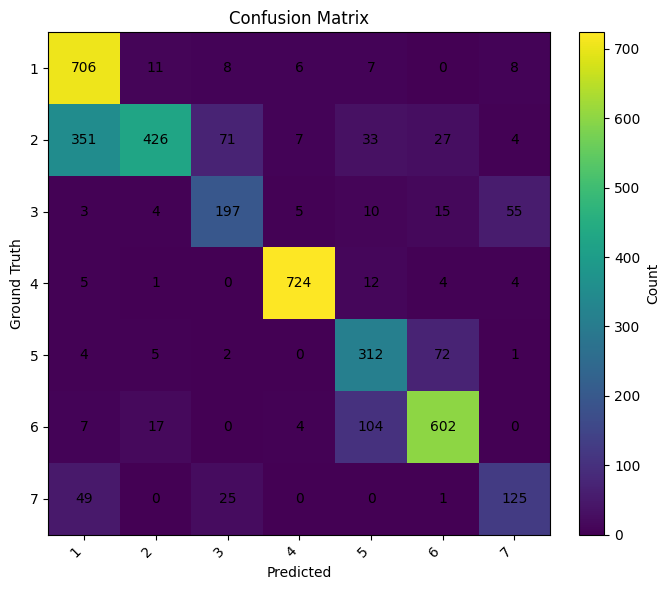


Results for cot:
{'confusion_matrix': [[706, 11, 8, 6, 7, 0, 8],
                      [351, 426, 71, 7, 33, 27, 4],
                      [3, 4, 197, 5, 10, 15, 55],
                      [5, 1, 0, 724, 12, 4, 4],
                      [4, 5, 2, 0, 312, 72, 1],
                      [7, 17, 0, 4, 104, 602, 0],
                      [49, 0, 25, 0, 0, 1, 125]],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'macro_f1': 0.7393366891720862,
 'per_class_f1': [0.7546766435061465,
                  0.6160520607375272,
                  0.6655405405405406,
                  0.9679144385026738,
                  0.7139588100686499,
                  0.8274914089347079,
                  0.6297229219143576],
 'weighted_f1': 0.7594121547582366}

Running prompt: few_shot 
Batch 1/2 (10 topics)...
Batch 2/2 (9 topics)...
[Saved] results/category_alignment/few_shot_metrics.json


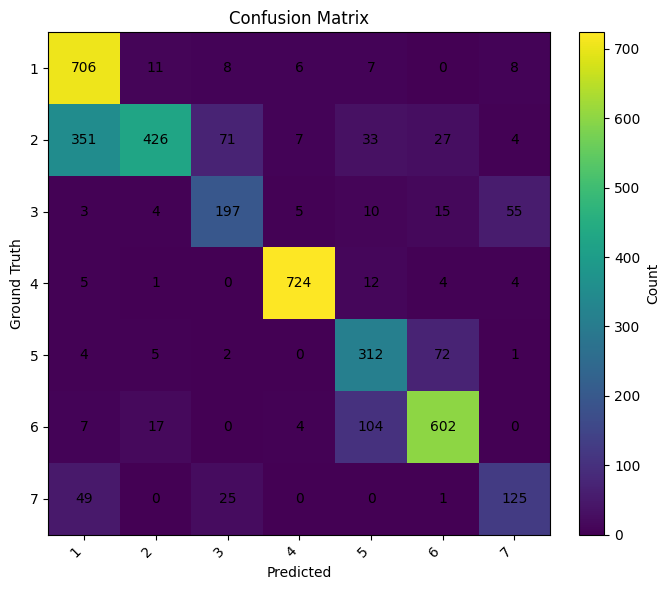


Results for few_shot:
{'confusion_matrix': [[706, 11, 8, 6, 7, 0, 8],
                      [351, 426, 71, 7, 33, 27, 4],
                      [3, 4, 197, 5, 10, 15, 55],
                      [5, 1, 0, 724, 12, 4, 4],
                      [4, 5, 2, 0, 312, 72, 1],
                      [7, 17, 0, 4, 104, 602, 0],
                      [49, 0, 25, 0, 0, 1, 125]],
 'labels': [1, 2, 3, 4, 5, 6, 7],
 'macro_f1': 0.7393366891720862,
 'per_class_f1': [0.7546766435061465,
                  0.6160520607375272,
                  0.6655405405405406,
                  0.9679144385026738,
                  0.7139588100686499,
                  0.8274914089347079,
                  0.6297229219143576],
 'weighted_f1': 0.7594121547582366}

Evaluation Summary:


,prompt,macro_f1,weighted_f1,samples,avg_topic_prob
0,baseline,0.647263,0.717021,4034,0.676777
1,no_others,0.739337,0.759412,4034,0.676777
2,cot,0.739337,0.759412,4034,0.676777
3,few_shot,0.739337,0.759412,4034,0.676777


In [178]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

# Batch params
BATCH_SIZE = 10
PAUSE_SEC = 60

all_results = {}
eval_summary = []

CATEGORY_NAME_MAP = {
    1: "Computers & Technology",
    2: "Science & Engineering",
    3: "Recreation (Vehicles & Hobbies)",
    4: "Sports",
    5: "Religion",
    6: "Politics & Society",
    7: "Marketplace / Miscellaneous"
}
CATEGORY_NAME_TO_INT = {v: k for k, v in CATEGORY_NAME_MAP.items()}

for prompt_name in PROMPT_VARIATIONS.keys():
    print(f"\nRunning prompt: {prompt_name} ")
    labels_list = []

    # Batch loop
    for i in range(0, len(topics), BATCH_SIZE):
        batch = topics.iloc[i:i+BATCH_SIZE]
        print(f"Batch {i//BATCH_SIZE + 1}/{(len(topics)-1)//BATCH_SIZE + 1} ({len(batch)} topics)...")

        labels_chunk = label_topics_from_df(batch, api_key=api_key, prompt_name=prompt_name)
        labels_list.append(labels_chunk)
        time.sleep(PAUSE_SEC)

    # Combine all labeled topics for this prompt
    labels_prompt = pd.concat(labels_list, ignore_index=True)
    all_results[prompt_name] = labels_prompt

    # Merge with suffixes to avoid clashes
    test_with_preds = test_df.merge(
        labels_prompt[["Topic", "tuned_topic_name"]],
        on="Topic",
        how="left",
        suffixes=("", "_pred")
    )

    # Filter
    test_filtered = test_with_preds[test_with_preds["Topic"] != -1].copy()
    test_filtered = test_filtered.dropna(subset=["tuned_topic_name_pred"])
    test_filtered["predicted_topic_id"] = (
        test_filtered["tuned_topic_name_pred"].map(CATEGORY_NAME_TO_INT).fillna(-1).astype(int)
    )
    test_filtered = test_filtered[test_filtered["predicted_topic_id"] != -1]

    # Run evaluation
    results = compute_category_alignment(
        test_filtered["predicted_topic_id"].astype("int64"),
        test_filtered["label"].astype("int64"),
        run_name=prompt_name,
        plot_confusion=True
    )

    print(f"\nResults for {prompt_name}:")
    pprint.pprint(results)

    # Store summary, including avg confidence
    eval_summary.append({
        "prompt": prompt_name,
        "macro_f1": results["macro_f1"],
        "weighted_f1": results["weighted_f1"],
        "samples": len(test_filtered),
        "avg_topic_prob": test_filtered["Topic_Probability"].mean()
    })

# Compare results
summary_df = pd.DataFrame(eval_summary)
print("\nEvaluation Summary:")
display(summary_df)


## Prompts Used:

### **Baseline prompt**:

You are a News Analytics assistant analyzing article clusters.
Produce a concise, meaningful topic label and a short explanation.
Guidelines:
- Only cluster topics into these categories: "Computers & Technology", "Science & Engineering", "Recreation (Vehicles & Hobbies)", "Sports", "Religion", "Politics & Society", "Marketplace / Miscellaneous"
- Avoid generic or vague labels; be as specific as possible.
- If you are unsure, you are allowed to cluster it as Others.

Return ONLY valid JSON with keys:
{{
  "tuned_topic_name": "string",
  "short_explanation": "string"
}}

keywords = {keywords[:5]}
representative_feedback = {[d[:50] for d in rep_docs[:8]]}




### **Baseline with no 'Others' category prompt**:


You are a News Analytics assistant analyzing article clusters.
Produce a concise, meaningful topic label and a short explanation.
Guidelines:
- Only use: "Computers & Technology", "Science & Engineering", "Recreation (Vehicles & Hobbies)", "Sports", "Religion", "Politics & Society", "Marketplace / Miscellaneous"
- You MUST choose one of the 7 categories. Do not use Others.

Return ONLY valid JSON with keys:
{{
  "tuned_topic_name": "string",
  "short_explanation": "string"
}}

keywords = {keywords[:5]}
representative_feedback = {[d[:50] for d in rep_docs[:8]]}



### **COT prompt**:

You are a News Analytics assistant analyzing article clusters.

Think step-by-step to classify this cluster:
1. Examine the keywords.
2. Check representative documents.
3. Choose the most appropriate category from:
   "Computers & Technology", "Science & Engineering", "Recreation (Vehicles & Hobbies)", "Sports", "Religion", "Politics & Society", "Marketplace / Miscellaneous"

Return ONLY valid JSON with keys:
{{
  "tuned_topic_name": "string",
  "short_explanation": "string"
}}

keywords = {keywords[:5]}
representative_feedback = {[d[:50] for d in rep_docs[:8]]}



### **Few-shot prompt**:

You are a News Analytics assistant analyzing article clusters.

Here are some examples of correct classifications:

Example 1:
keywords: ["drive", "card", "windows", "scsi", "disk"]
docs: ["hard drive controllers", "windows compatibility issues"]
→ "Computers & Technology" - Cluster about computer hardware.

Example 2:
keywords: ["team", "game", "season", "hockey", "play"]
docs: ["tampa bay vs philadelphia game", "team standings"]
→ "Sports" - Cluster about hockey games.

Example 3:
keywords: ["space", "nasa", "orbit", "satellite", "launch"]
docs: ["nasa mission update", "satellite in orbit"]
→ "Science & Engineering" - Cluster about space exploration.

Now classify this cluster into one of:
"Computers & Technology", "Science & Engineering", "Recreation (Vehicles & Hobbies)", "Sports", "Religion", "Politics & Society", "Marketplace / Miscellaneous"

Return ONLY valid JSON with keys:
{{
  "tuned_topic_name": "string",
  "short_explanation": "string"
}}

keywords = {keywords[:5]}
representative_feedback = {[d[:50] for d in rep_docs[:8]]}